# vision

> 对于图片/视频的处理

In [ ]:
#| default_exp vision

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from wcpdtoolbox.imports import *

In [ ]:
path = untar_data(url=URLs.PETS)
imgs = get_image_files(path/'images')
vid_path = '/ailearn/dataset/video/own/20230127_032459.mp4'

## Img

### open

In [ ]:
#| export
def openimg_cv2(path):
    img = cv2.imread(str(path))
    return img

使用xyz色彩空间打开图片,并转化为4d tensor

In [ ]:
#| export
def img2xyz(img):
    img = img.astype(np.uint16)*255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2XYZ).astype(np.float32)/(65535)
    img = torch.from_numpy(img)
    img = torch.unsqueeze(img, 0).permute(0, 3, 1, 2) if img.dim() == 3 else img.permute(0, 3, 1, 2)
    return img

In [ ]:
#| export
def openimgxyz(path): return img2xyz(openimg_cv2(path))

In [ ]:
img = openimgxyz(imgs[0])

### show

In [ ]:
#| export
def showimgxyz(img):
    l = L()
    if len(img.shape) == 3:
        i = img.permute(1, 2, 0).cpu().detach().numpy()*255
        i = cv2.cvtColor(i, cv2.COLOR_XYZ2RGB).astype(np.uint8)
        l.append(PILImage.create(i))
    else:
        for i in img:
            i = i.permute(1, 2, 0).cpu().detach().numpy()*255
            i = cv2.cvtColor(i, cv2.COLOR_XYZ2RGB).astype(np.uint8)
            l.append(PILImage.create(i))
    return l

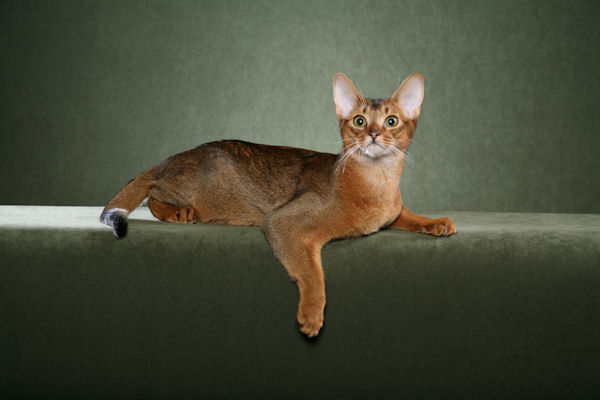

In [ ]:
showimgxyz(img)[0]

### Transform

一组转换

In [ ]:
#| export
def imgxyzpipe(): return Transform(enc=openimgxyz, dec=showimgxyz)

In [ ]:
imgxyz = imgxyzpipe()

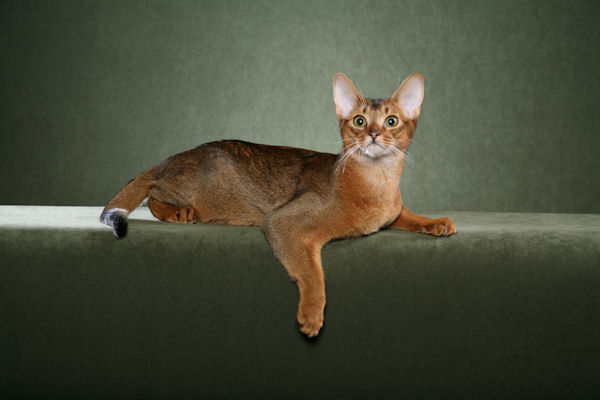

In [ ]:
imgxyz.decode(imgxyz(imgs[0]))[0]

### Process

#### Pick

使用F.grid_sample拾取图片

In [ ]:
#| export
class PickImg(nn.Module):
    '''使用F.grid_sample拾取图片'''

    def __init__(self, device="cpu", return_grid=False,):
        super().__init__()
        self.device = device
        self.mat_val = torch.tensor([[0, 1, 1, 0, 0.]]).to(device)
        self.to(device)
        self.return_grid = return_grid
        # self.comb_grid = comb_grid
        
    def get_grid_mat(self, val:Tensor=None):
        '''zeta=0, mult_x=1, mult_y=1, offset_x=0, offset_y=0'''
        if val == None:
            val = self.mat_val

        s0 = torch.stack([torch.cos(val[:, 0])/val[:, 1], -torch.sin(val[:, 0])/val[:, 1], val[:, 3]])
        s1 = torch.stack([torch.sin(val[:, 0])/val[:, 2], torch.cos(val[:, 0])/val[:, 2], val[:, 4]])

        s = torch.stack([s0, s1]).permute(2, 0, 1).reshape(-1, 2, 3)
        return s.to(self.device)

    def create_grid(self, mats:Tensor, pick_size:list):
        # use mat to create grid, pick_size:
        # mats.shape[0] should eq to pick_size[0]
        pick_size = torch.Size(pick_size)
        return F.affine_grid(mats, pick_size).to(self.device)

    def create_grid_by_matval(self, pick_size, matval:Tensor=None):
        # use mat val to create grid
        mats = self.get_grid_mat(matval)
        return self.create_grid(mats, pick_size).to(self.device)
    
    def create_basic_grid(self, img:Tensor, pick_size:list):
        mat = self.get_grid_mat().repeat(img.shape[0], 1, 1).to(self.device)
        basic_grid = self.create_grid(mat, pick_size)
        return basic_grid.to(self.device)
    
    def create_img_with_grid(self, img): return torch.hstack((self.create_basic_grid(img, img.size()).permute(0,3,1,2),img))

    def forward(self,
                img:Tensor, # 4d img
                pick_size:list=[32,32], # like [32, 32]
                grid=None, # Size([n,x,y,c])
                matval=None,  # like [[0,0,0,0,0]]
               ):
        
        if grid != None:
            pick_size = [grid.shape[0],img.shape[1]] + pick_size
            img = img.expand(grid.shape[0], *img.shape[1:])
            img = F.grid_sample(img, grid, padding_mode="reflection").to(self.device)
            return (img, grid) if self.return_grid else img
        
        if matval != None:
            pick_size = [matval.shape[0],img.shape[1]] + pick_size
            img = img.expand(matval.shape[0], *img.shape[1:])
            matval = tensor(matval).float()
            grid = self.create_grid_by_matval(pick_size, matval)
            img = F.grid_sample(img, grid, padding_mode="reflection").to(self.device)
            return (img, grid) if self.return_grid else img
        
        pick_size = [img.shape[0],img.shape[1]] + pick_size
        grid = self.create_basic_grid(img, pick_size)
        img = F.grid_sample(img, grid, padding_mode="reflection").to(self.device)
        return (img, grid) if self.return_grid else img

In [ ]:
pick = PickImg()

缩放至尺寸

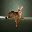

In [ ]:
picked_img = pick(img)
showimgxyz(picked_img)[0]

使用matval:zeta=0, mult_x=1, mult_y=1, offset_x=0, offset_y=0

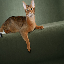

In [ ]:
picked_img = pick(img, [64,64], matval=pick.mat_val+0.2)
showimgxyz(picked_img)[0]

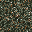

In [ ]:
picked_img = pick(img, grid=torch.randn(1,32,32,2))
showimgxyz(picked_img)[0]

## Video

### open

使用opencv打开视频

并行读取

In [ ]:
class VideoGet:
    def __init__(self, src, queue):
        
        self.stream = cv2.VideoCapture(src)
        self.grabbed, self.frame = self.stream.read()
        self.stopped = False
        self.q = queue
        
        frame = self.frame
        self.q.put(frame)
    
    def start(self):
        self.t = Thread(target=self._get, args=()).start()

    def _get(self):
        while not self.stopped:
            if not self.grabbed:
                self.stop()
            else:
                self.grabbed, self.frame = self.stream.read()
                frame = self.frame
                self.q.put(frame)

    def stop(self):
        self.stopped = True

把视频转换为np数组

In [ ]:
#| export
def load_video(src, max_frame=None):
    t = 0
    q = Queue(max_frame if max_frame != None else 0)
    v = VideoGet(src, q)
    l = [q.get()[None,:]]
    v.start()
    t += 1
    # time.sleep(0.2)
    while True:
        if not((v.stopped) and q.empty() or ((t >= max_frame) if max_frame != None else False)):
            frame = q.get()
            if not isinstance(frame, NoneType) : 
                l.append(frame[None,:])
                t += 1
        else:
            v.stop()
            break
    return np.vstack(tuple(l))

In [ ]:
l = load_video(vid_path)

In [ ]:
l.shape

(328, 1440, 1440, 3)

### save

使用ffmpeg保存视频

### pull

使用ffmpeg推流

推流

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()